#### Data 620 - Project 2 <br>June 26, 2019<br>Team 2: <ul><li>Anthony Munoz</li> <li>Katie Evers</li> <li>Juliann McEachern</li> <li>Mia Siracusa</li></ul>

<h1 align="center">Network Analysis: 2-Mode Networks</h1>

<h2 style="color:#088A68;">Project Overview</h2>

We will be examining datasets from a Nowegian [Boards and Gender](http://www.boardsandgender.com/data.php) study. The purpose of the study was to evaluate the effect gender representation laws had on the gender composition of companies' Board of Directors within Norway.

We choose to look at their 2-Mode Network from July 2011. We first examined the network using a bipartite approach. Then, we  implored the island method from our Social Network Analysis text to see if we could derive any significant conclusions about our network. Our results are outlined in our conclusion section.

<h2 style="color:#088A68;">Getting Started: 2-Mode Network</h2>

In a 2-Mode network, "there are two different types of nodes and links determine relationships between one set of nodes and the other." (Tsvetovat & Kouznetsov 96). In the following steps, we loaded our python dependencies and combined our datasets using pandas transformations.

We will be examining the connection between board of directors and organizations. Both factors will treated  as distinct groups. We will retain the gender feature for directors and use this feature when coloring our graph later on. 

#### Python Dependencies 

In [15]:
import pandas as pd, networkx as nx,matplotlib.pyplot as plt, numpy as np, warnings, seaborn as sns 
from networkx.algorithms import bipartite

warnings.filterwarnings('ignore') 

#### Load & Transform Network Data

Data was loaded and merged into a pandas dataframe. Unused columns were dropped and some column were renamed for better understanding of our dataset. A weight was assigned to each row by based on unique organization connections to grouped directors. 

In [2]:
#affiliation of directors to organizational boards
net2m = pd.read_csv('http://www.boardsandgender.com/data/net2m/net2m_2011-07-01.txt', sep=" ", header=None)
net2m.columns=["director", "board"]
#company attributes
comp = pd.read_csv('https://raw.githubusercontent.com/jemceach/620/master/Project-2/companies.csv', header=None)
comp.columns=["id", "org_no","org_name","postcode_city"]; comp=comp.drop(["org_no","postcode_city"], axis=1)
#people attributes
ppl = pd.read_csv('https://raw.githubusercontent.com/jemceach/620/master/Project-2/peoples.csv',encoding = "ISO-8859-1")
ppl['gender'] = ppl['gender'].replace(1, "M").replace(2, "F")
#merge datasets
net2m=net2m.merge(ppl, left_on='director', right_on='id').drop("id",axis=1).merge(comp, left_on='board', right_on='id').drop("id",axis=1)
#add weight using unique counts 
net2m['weight'] = net2m.groupby('director')['board'].nunique()+1; net2m=net2m.replace(np.nan, 1).sort_values("weight")
# save ids for network graph labels
ids = net2m.set_index('director')
#preview data
net2m.sort_values("board").head()

,director,board,name,gender,org_name,weight
27,67,3,Allan Boye Hansen,M,ABERDEEN EIENDOMSFOND ASIA ASA,3.0
28,109,3,Anders Talleraas,M,ABERDEEN EIENDOMSFOND ASIA ASA,2.0
81,230,10,Anne Gro Sundby,F,ACTA ASSET MANAGEMENT ASA,1.0
41,106,11,Anders Skjævestad,M,ACTA HOLDING ASA,1.0
70,190,13,Anne-Lise Aspengren,F,AF GRUPPEN ASA,1.0


<h2 style="color:#088A68;">Biparthite Graph</h2>

We choose to first examine our network as a biparthite graph. The biparthite layout decomposed graph vertices into two disjoint sets for us to evalutate. In a biparthite network, in the same biparthite are note meant to ever connect with one another (ie two corporation will never be linked).

#### Build Network

We built our network by looping through our dataset to add 2 sets of bipartite nodes. These nodes were added with the node attribute set to "bipartite". Edges were added only between nodes of opposite bipartite node sets.

In [3]:
B = nx.Graph()

# add director nodes as bipartite 0
for i in range(len(net2m)): 
    B.add_node(net2m.iloc[i][0],
                bipartite=0)
    
# add organization nodes as bipartite 1
for i in range(len(net2m)): 
    B.add_node(net2m.iloc[i][4],
               bipartite=1)

# connect edges from both bipartite 0 and 1
for i in range(len(net2m)):
    B.add_edge(net2m.iloc[i][0], net2m.iloc[i][4], weight=net2m.iloc[i][5])

# identify top and bottom nodes
top_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
bottom_nodes = set(B) - top_nodes

# verification
print("Verify graph is_bipartite:",nx.is_bipartite(B))

Verify graph is_bipartite: True


#### Biparthite Network Evaluation
The biadjacency matrix heatmap represents when two of our nodes are adjacent to one another. The map shows spacity between our two verticies as nodes of the same group are never adjacent with one another.

Average clustering: 0.2866096866096866


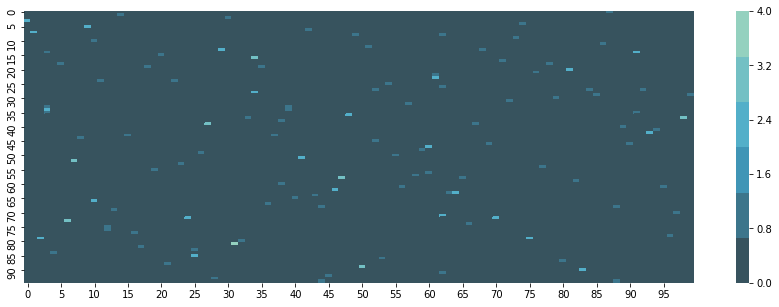

In [89]:
print("Average clustering:", bipartite.cluster.average_clustering(B))

plt.figure(figsize=(15,5))
matrix=bipartite.matrix.biadjacency_matrix(B, top_nodes).todense()
sns.heatmap(matrix,xticklabels=5,yticklabels=5, cmap=sns.color_palette('GnBu_d'))
plt.show()

#### Biparthite Centrality Measures

In [77]:
# evaluate average centrality measures between bipartite groups

top_cm = pd.DataFrame()
top_cm['top_closeness']=bipartite.centrality.closeness_centrality(B, top_nodes).values()
top_cm['top_degree']=bipartite.centrality.degree_centrality(B, top_nodes).values()
top_cm['top_betweenness']=bipartite.centrality.betweenness_centrality(B, top_nodes).values()

bottom_cm = pd.DataFrame()
bottom_cm['bottom_closeness']=bipartite.centrality.closeness_centrality(B, bottom_nodes).values()
bottom_cm['bottom_degree']=bipartite.centrality.degree_centrality(B, bottom_nodes).values()
bottom_cm['bottom_betweenness']=bipartite.centrality.betweenness_centrality(B, bottom_nodes).values()

top_centrality=top_cm.describe()
bottom_centrality=bottom_cm.describe()

# view average centrality measures
centrality=pd.merge(top_centrality,bottom_centrality,left_index=True, right_index=True)
centrality.drop('count', axis=0).drop('std', axis=0)

Average clustering: 0.2866096866096866


,top_closeness,top_degree,top_betweenness,bottom_closeness,bottom_degree,bottom_betweenness
mean,1.321466,0.012421,0.000017,1.321466,0.012421,0.000017
min,0.629296,0.010000,0.000000,0.629296,0.010000,0.000000
25%,1.006873,0.010000,0.000000,1.006873,0.010000,0.000000
50%,1.484536,0.010526,0.000000,1.484536,0.010526,0.000000
75%,1.510309,0.010526,0.000000,1.510309,0.010526,0.000000
max,1.510309,0.042105,0.000537,1.510309,0.042105,0.000537


#### Examine Network

The output below highlights some basic features of our network.

In [4]:
print("\nNetwork",nx.info(B))

print("\nList degrees:", B.degree())


Network Name: 
Type: Graph
Number of nodes: 195
Number of edges: 118
Average degree:   1.2103

List degrees: [(3, 1), (220, 2), (219, 1), (214, 1), (211, 1), (210, 1), (198, 1), (190, 1), (187, 1), (217, 1), (181, 2), (175, 1), (158, 2), (154, 1), (149, 1), (366, 1), (147, 2), (227, 1), (144, 1), (143, 2), (225, 1), (133, 2), (230, 2), (239, 2), (350, 1), (349, 1), (341, 1), (335, 1), (334, 1), (333, 1), (315, 1), (310, 1), (309, 1), (302, 1), (300, 1), (298, 1), (276, 1), (268, 1), (373, 2), (266, 2), (264, 1), (248, 1), (243, 1), (132, 2), (368, 1), (118, 1), (79, 2), (73, 2), (28, 1), (22, 1), (72, 1), (52, 1), (61, 1), (54, 2), (136, 2), (27, 2), (120, 1), (104, 1), (37, 1), (85, 1), (115, 1), (34, 1), (114, 2), (5, 1), (177, 1), (106, 3), (15, 1), (103, 1), (7, 1), (97, 2), (361, 1), (95, 1), (58, 2), (277, 1), (18, 1), (313, 2), (24, 1), (338, 1), (11, 1), (360, 1), (280, 2), (235, 1), (259, 1), (142, 1), (109, 1), (200, 1), (83, 1), (183, 1), (96, 1), (156, 1), (289, 1), (356, 

#### Visualize Network

The bipartite layout below helps visualize our connections by positioning our nodes in two straight lines. This graph shows us the connections between director and their board affiliation.

C:\Users\15082\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


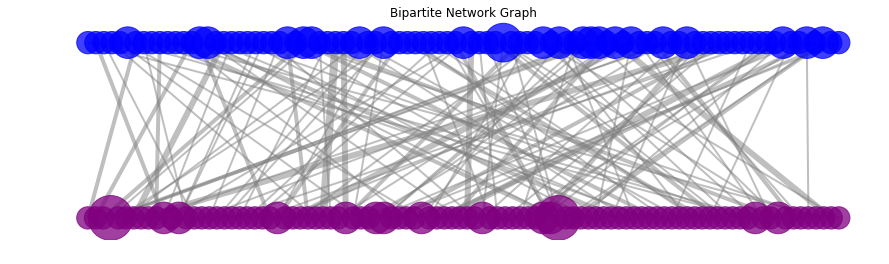

In [50]:
plt.figure(figsize=(15, 4))
           
# set layout position
pos=nx.bipartite_layout(B,top_nodes, align='horizontal') 


colors=[]
color=bipartite.color(B)
for n, c in B.nodes('bipartite'):
    if (c == 1 ):
        colors.append('purple')
    else:
        colors.append('blue')

# nodes
d = B.degree()
nx.draw_networkx_nodes(B,pos, node_color=colors, node_size=[v*500 for v in dict(d).values()], alpha=0.75)

# edges drawn with widths set to edge weight
nx.draw_networkx_edges(B,pos,alpha=0.5,width=[c*2 for (u, v, c) in B.edges.data('weight')],edge_color='grey',style='solid')

plt.axis('off')
plt.title('Bipartite Network Graph')
plt.show()

## Network Reduction

#### Island Method
The island method is a way to split up a large data set into smaller sections with more activity. These smaller sections can then be analyzed individually. Essentially, the large component is "flooded" and the valleys, or the areas data sets with the least edges, are submerged into water. The water, essentially a threshold on the edge values, thus breaks the large component into smaller pieces, or "islands".

We explored this technique using the island method as described in chapter 4 of our Social Network Analysis text.

In [6]:
## Implementing the Island Method to look for important subgroups. 
def trim_edges(b, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    b2 = nx.Graph()
    for u, v, c in B.edges(data=True):
        if c['weight'] > weight:
            b2.add_edge(u,v, weight=c)
    return b2

## Return list of graphs each corresponding to different thresholds
def island_method(B, iterations=3):
    weights= [c for (u, v, c) in B.edges.data('weight')]
    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of step
    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(B, threshold)] for threshold in range(mn,mx,step)]

#### Island Output

By calling the `island_method` function below, we trim our edges to exclude singular node connections. Our network is now separated here into 59 nodes on 28 island subgraphs. Upon our second and final iteration, our threshold of 2 indicates that our graph contains 16 influencial nodes on 8 islands. And, there are only 2 connections between each.

In [79]:
cc=list(nx.connected_component_subgraphs(B))[1]
island = island_method(cc, iterations = 2)

#print the threshold level, size of the graph, and number of connected components
for i in island:
    print("Threshold:",i[0], "Size:",len(i[1]), "Connections:", len(list(nx.connected_component_subgraphs(i[1]))))

Threshold: 1 Size: 59 Connections: 28
Threshold: 2 Size: 16 Connections: 8


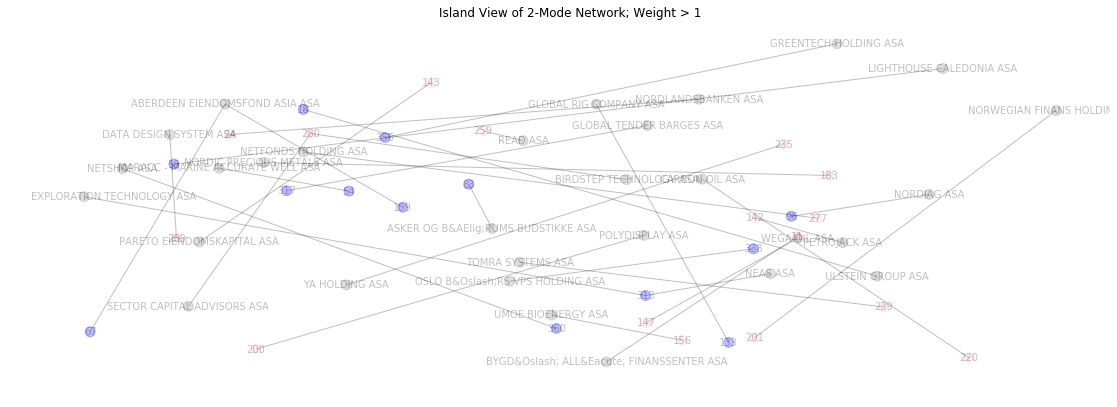

In [8]:
plt.figure(figsize=(15, 5))

# Apply island method
B1=trim_edges(B,weight=1)

# Set node color based on gender
male = set(net2m[net2m['gender']=="M"].iloc[:, 0].unique())
female = set(net2m[net2m['gender']=="F"].iloc[:, 0].unique())

nodecolors=[]
for n in dict(B1.degree()).keys():
    if n in male:
        nodecolors.append('blue')
    elif n in female:
        nodecolors.append('pink')
    else:
        nodecolors.append('grey')

nx.draw_random(B1, node_size=100, alpha=.25, font_size=10, with_labels=True, node_color=nodecolors)

plt.axis('off')
plt.title('Island View of 2-Mode Network; Weight > 1')
plt.show()

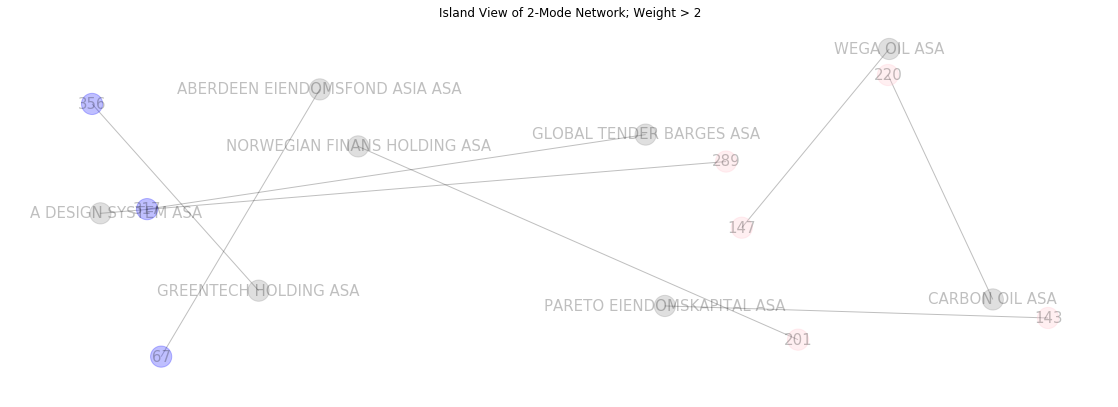

In [9]:
plt.figure(figsize=(15, 5))

# Apply island method
B2=trim_edges(B,weight=2)
    
# iteration makes assign color to nodes by gender 
nodecolors=[]
for n in dict(B2.degree()).keys():
    if n in male:
        nodecolors.append('blue')
    elif n in female:
        nodecolors.append('pink')
    else:
        nodecolors.append('grey')

# draw network
nx.draw_random(B2, node_size=450, alpha=.25, font_size=15, with_labels=True, node_color=nodecolors)

plt.axis('off')
plt.title('Island View of 2-Mode Network; Weight > 2')
plt.show()

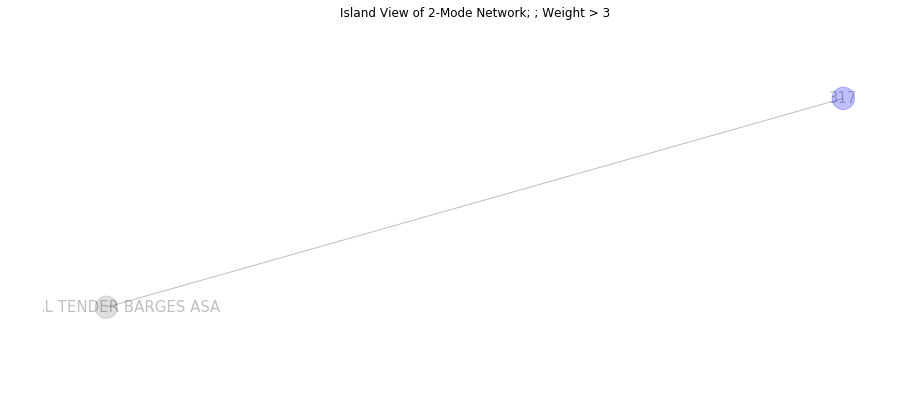

In [10]:
plt.figure(figsize=(12, 5))
B3=trim_edges(B,weight=3)
  
# iteration makes assign color to nodes by gender 
nodecolors=[]
for n in dict(B3.degree()).keys():
    if n in male:
        nodecolors.append('blue')
    elif n in female:
        nodecolors.append('pink')
    else:
        nodecolors.append('grey')

# draw network
nx.draw_random(B3, node_size=500, alpha=.25, font_size=15, with_labels=True, node_color=nodecolors)
plt.axis('off'); plt.title('Island View of 2-Mode Network; ; Weight > 3'); plt.show()

## Analysis 
+ What can you infer about each of the distinct groups?

## Video Presentation

Our recorded submission can be viewed in the embedded video player below: 

In [11]:
%%html

UsageError: %%html is a cell magic, but the cell body is empty.


---
#### References

1. Social Network Analysis for Startups, Maksim Tsvetovat and Alexander Kouznetsov, O'Reilly, Sep 30, 201
2. Seierstad, C., Opsahl, T. (2011). For the few not the many? The effects of affirmative action on presence, prominence, and social capital of female directors in Norway. Scandinavian Journal of Management 27 (1), 44-54, doi: 10.1016/j.scaman.2010.10.002; 
3. NetworkX Bipartite Algorithm. Retrieved from https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html 